In [1]:
library(foreign)
library(ggplot2)
library(truncreg)
library(boot)

Loading required package: maxLik
Loading required package: miscTools

Please cite the 'maxLik' package as:
Henningsen, Arne and Toomet, Ott (2011). maxLik: A package for maximum likelihood estimation in R. Computational Statistics 26(3), 443-458. DOI 10.1007/s00180-010-0217-1.

If you have questions, suggestions, or comments regarding the 'maxLik' package, please use a forum or 'tracker' at maxLik's R-Forge site:
https://r-forge.r-project.org/projects/maxlik/


### Examples of truncated regression

### Description of the data

In [2]:
dat <- read.dta("./datasets/truncreg.dta")
summary(dat)

       id             achiv         langscore           prog    
 Min.   :  3.00   Min.   :41.00   Min.   :31.00   general : 40  
 1st Qu.: 55.25   1st Qu.:47.00   1st Qu.:47.50   academic:101  
 Median :102.50   Median :52.00   Median :56.00   vocation: 37  
 Mean   :103.62   Mean   :54.24   Mean   :54.01                 
 3rd Qu.:151.75   3rd Qu.:63.00   3rd Qu.:61.75                 
 Max.   :200.00   Max.   :76.00   Max.   :67.00                 

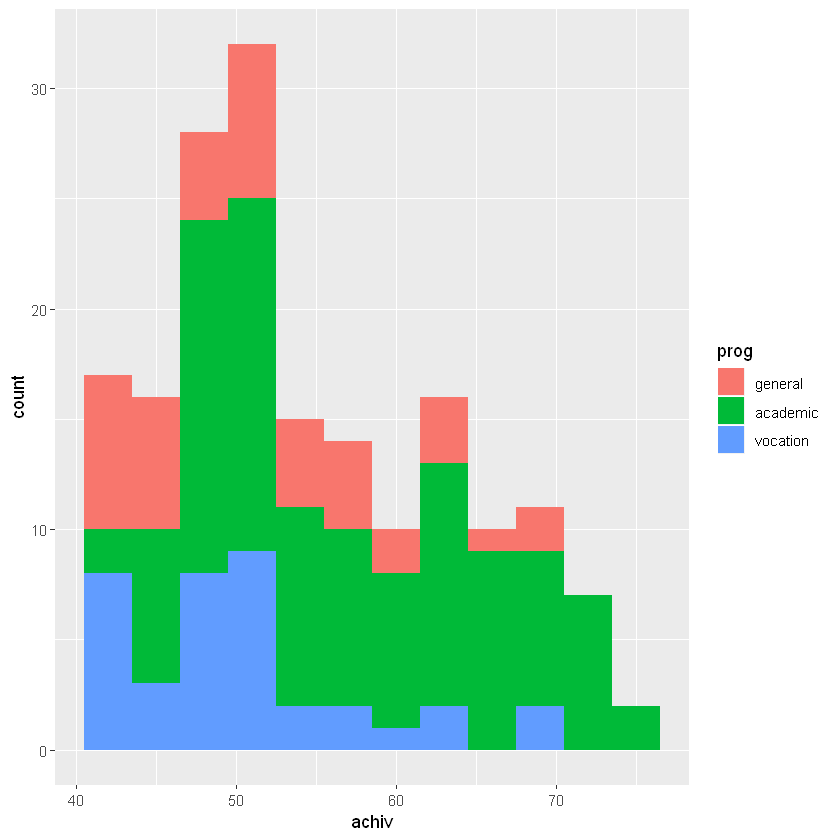

In [3]:
# histogram of achiv coloured by program type
ggplot(dat, aes(achiv, fill = prog)) + geom_histogram(binwidth=3)

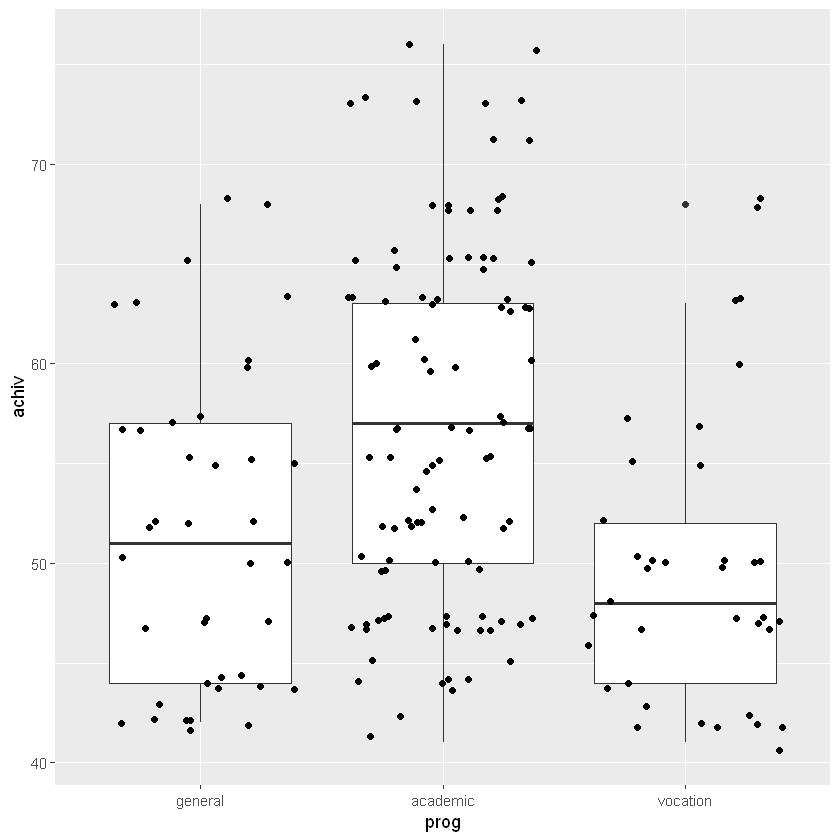

In [4]:
# boxplot of achiv by program type
ggplot(dat, aes(prog, achiv)) + geom_boxplot() + geom_jitter()

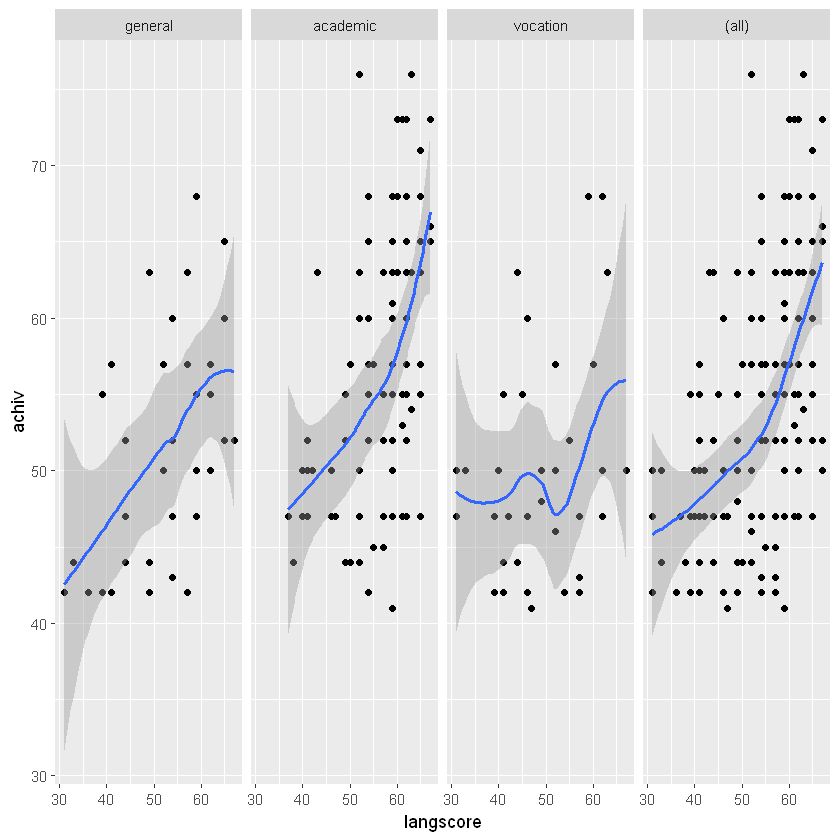

In [5]:
ggplot(dat, aes(x = langscore, y = achiv)) +
    geom_point() + stat_smooth(method = "loess") + facet_grid(. ~ prog, margins=TRUE)

### Analysis methods you might consider

### Truncated regression

In [6]:
m <- truncreg(achiv ~ langscore + prog, data = dat, point = 40, direction = "left")
summary(m)


Call:
truncreg(formula = achiv ~ langscore + prog, data = dat, point = 40, 
    direction = "left")

BFGS maximization method
57 iterations, 0h:0m:0s 
g'(-H)^-1g = 2.5E-05 
 


Coefficients :
             Estimate Std. Error t-value  Pr(>|t|)    
(Intercept)  11.29942    6.77173  1.6686   0.09519 .  
langscore     0.71267    0.11446  6.2264 4.773e-10 ***
progacademic  4.06267    2.05432  1.9776   0.04797 *  
progvocation -1.14422    2.66958 -0.4286   0.66821    
sigma         8.75368    0.66647 13.1343 < 2.2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Log-Likelihood: -591.31 on 5 Df

In [7]:
# update old model dropping prog
m2 <- update(m, . ~ . - prog)

pchisq(-2 * (logLik(m2) - logLik(m)), df = 2, lower.tail = FALSE)

'log Lik.' 0.02516651 (df=3)

In [8]:
# create mean centered langscore to use later
dat <- within(dat, {mlangscore <- langscore - mean(langscore)})

malt <- truncreg(achiv ~ 0 + mlangscore + prog, data = dat, point = 40)
summary(malt)


Call:
truncreg(formula = achiv ~ 0 + mlangscore + prog, data = dat, 
    point = 40)

BFGS maximization method
21 iterations, 0h:0m:0s 
g'(-H)^-1g = 4.3E-07 
 


Coefficients :
             Estimate Std. Error t-value  Pr(>|t|)    
mlangscore    0.71259    0.11448  6.2248  4.82e-10 ***
proggeneral  49.78926    1.89714 26.2443 < 2.2e-16 ***
progacademic 53.85340    1.15012 46.8242 < 2.2e-16 ***
progvocation 48.65315    2.14049 22.7299 < 2.2e-16 ***
sigma         8.75545    0.66684 13.1299 < 2.2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Log-Likelihood: -591.31 on 5 Df

In [9]:
f <- function(data, i) {
     require(truncreg)
     m <- truncreg(formula = achiv ~ langscore + prog, data = data[i, ], point = 40)
     as.vector(t(summary(m)$coefficients[, 1:2]))  }

set.seed(10)
(res <- boot(dat, f, R = 1200, parallel = "snow", ncpus = 4))


ORDINARY NONPARAMETRIC BOOTSTRAP


Call:
boot(data = dat, statistic = f, R = 1200, parallel = "snow", 
    ncpus = 4)


Bootstrap Statistics :
       original        bias    std. error
t1*  11.2994158 -0.0750432302  5.91023663
t2*   6.7717257  0.0099996401  0.86430871
t3*   0.7126732  0.0019041192  0.09730007
t4*   0.1144602  0.0002004845  0.01366713
t5*   4.0626698 -0.0485288252  1.94566248
t6*   2.0543191  0.0076934779  0.24494415
t7*  -1.1442162  0.0425573767  2.81757637
t8*   2.6695799  0.0219657954  0.29789986
t9*   8.7536778 -0.0900719907  0.54763875
t10*  0.6664744 -0.0083607460  0.07505858

In [10]:
# basic parameter estimates with percentile and bias adjusted CIs
parms <- t(sapply(c(1, 3, 5, 7, 9), function(i) {
         out <- boot.ci(res, index = c(i, i + 1), type = c("perc", "bca"))
                with(out, c(Est = t0, pLL = percent[4], pUL = percent[5], bcaLL = bca[4], bcaLL = bca[5]))  }))

# add row names
row.names(parms) <- names(coef(m))

# print results
parms

,Est,pLL,pUL,bcaLL,bcaLL
(Intercept),11.2994158,-0.47667113,22.8722200,-0.55662632,22.8711476
langscore,0.7126732,0.52197893,0.9055977,0.52286226,0.9065408
progacademic,4.0626698,-0.06878459,7.8897378,0.04873108,7.9296538
progvocation,-1.1442162,-6.79210189,4.3581860,-6.92519441,4.0693050
sigma,8.7536778,7.62374802,9.7726403,7.86169145,9.9453352


In [11]:
dat$yhat <- fitted(m)

# correlation
(r <- with(dat, cor(achiv, yhat)))

[1] 0.5524392

In [12]:
# rough variance accounted for
r^2

[1] 0.305189

### Things to consider